# Text Classification in Cross-Validation using Long Short-Term Memory

## Import Libraries

In [29]:
import re
import time
import torch
import random
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from lime import lime_text
from torch import nn, optim
from sklearn import metrics
from string import punctuation
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Set Hyparameters

### Dataset Language Setting

In [30]:
language="italian"

language_w="../input/fasttext-aligned-word-vectors/wiki.it.align.vec"

### Model Parameters

In [31]:
batch_size = 128
dropout_pc = 0.5
n_epochs = 100
patience=5
hidden_dim=50
lr = 1e-3
num_layers=1
bidirectional=True

nfold=10

### Dataset Parameters

In [32]:
path_db="../input/ciao9cci/politica.xlsx"
df = pd.read_excel(path_db, sheet_name="Foglio1")

text="testo"
review="cap_maj_master"

n_top_class=35

## Enable GPU

In [33]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 2019
#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

## Load Dataset

In [34]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

output_dim = len(np.unique(classes))

[12.0, 10.0, 20.0, 1.0, 3.0, 15.0, 5.0, 6.0, 7.0, 19.0, 4.0, 9.0, 2.0, 16.0, 21.0, 8.0, 13.0, 17.0, 14.0, 23.0, 18.0]
Found 5672 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


## Class Distribution Diagram

Number of Classes found:  21


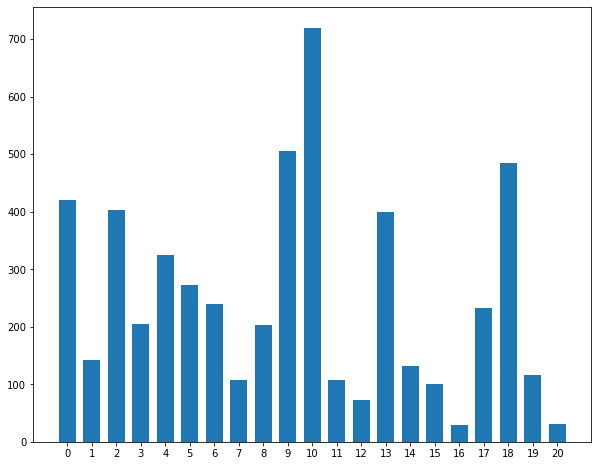

In [35]:
y = np.bincount(classes)
x = np.arange(len(y))
print("Number of Classes found: ", len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


## Define Preprocessor

In [36]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence
    
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

In [37]:
documents, vocab = split_words_documents(documents)

## Preprocessed Dataset Statistics

In [38]:
print("Max sequence length: ", np.max([len(x) for x in documents]))
print("Average sequence length: ",np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
hidden_dim=int(quant)
print("Quantile sequence length: ",quant)

Max sequence length:  1375
Average sequence length:  201.02611015818562
Quantile sequence length:  248.0


## Vocabulary Build

In [39]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [40]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

## Define Padding

In [41]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [42]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

## Pretrained Vector Loader

In [43]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [44]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:41, 21154.56it/s]


There are 135327 / 279895 pretrained vectors found.


## Utility Functions

In [45]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

### DataLoader Function

In [46]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

### Plot Function

In [47]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### EarlyStopping Function

In [48]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define Model

In [49]:
class ClassificationRNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                freeze_embedding=True,
                 n_vocab=None,
                 hidden_dim=100,
                 output_dim=13,
                 dropout = 0.8,
                 pad_idx=0.0,
                 num_layers=2,
                bidirectional=True):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(self.n_embed, 
                           hidden_dim,
                           num_layers=num_layers,
                          bidirectional=bidirectional,
                          dropout=0 if num_layers < 2 else dropout,
                          batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 4 if bidirectional else hidden_dim*2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        

        
        
    def forward(self, text, text_length):
        h_embedding = self.dropout(self.embedding(text))
        #packed = torch.nn.utils.rnn.pack_padded_sequence(h_embedding, text_length,batch_first=True, enforce_sorted=False)
        h_lstm, (h,c) = self.rnn(h_embedding)
        #h_lstm, output_lengths = nn.utils.rnn.pad_packed_sequence(h_lstm,batch_first=True)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        
        out=self.fc1(conc)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

## Evaluate Function

In [50]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

## Define Train Function

In [51]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

## Define Predict Function

In [52]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [53]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Cross-Validation Loop

train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  365.985438  | 294.623306 |   11.25   |   3.83   
Validation loss decreased (inf --> 294.623306).  Saving model ...
   2    |  357.458020  | 290.209014 |   11.25   |   3.82   
Validation loss decreased (294.623306 --> 290.209014).  Saving model ...
   3    |  339.597724  | 272.278008 |   17.19   |   3.84   
Validation loss decreased (290.209014 --> 272.278008).  Saving model ...
   4    |  321.874008  | 258.678012 |   19.06   |   3.84   
Validation loss decreased (272.278008 --> 258.678012).  Saving model ...
   5    |  296.724030  | 232.221576 |   28.73   |   3.83   
Validation loss decreased (258.678012 --> 232.221576).  Saving model ...
   6    |  258.931486  | 214.009157 |   40.82   |   3.86   
Validation loss decreased (232.221576 --> 214.009157).  Saving model ...


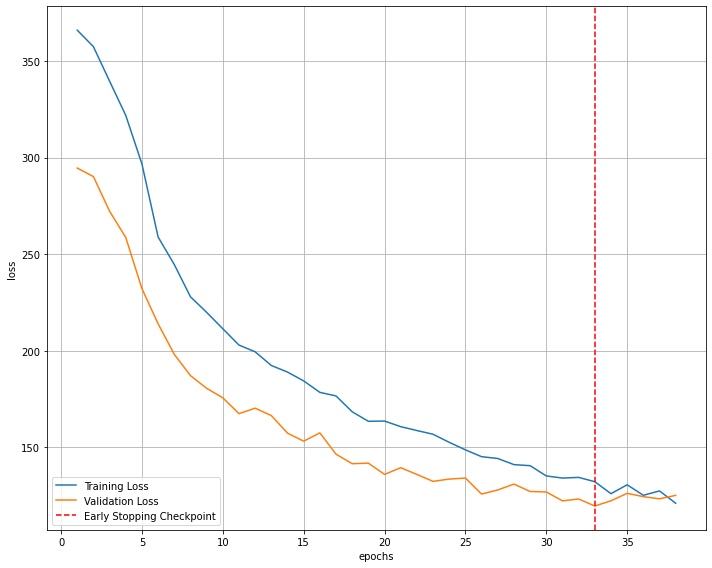

--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.62      0.48        42
           1       0.67      0.40      0.50        15
           2       0.86      0.90      0.88        40
           3       0.89      0.76      0.82        21
           4       0.72      0.66      0.69        32
           5       0.77      1.00      0.87        27
           6       0.46      0.71      0.56        24
           7       0.70      0.64      0.67        11
           8       0.64      0.45      0.53        20
           9       0.77      0.86      0.81        50
          10       0.69      0.82      0.75        72
          11       0.67      0.18      0.29        11
          12       0.00      0.00      0.00         7
          13       0.32      0.17      0.23        40
          14       0.83      0.38      0.53        13
          15       0.50      0.10      0.17        10
          16       0.00      0.00

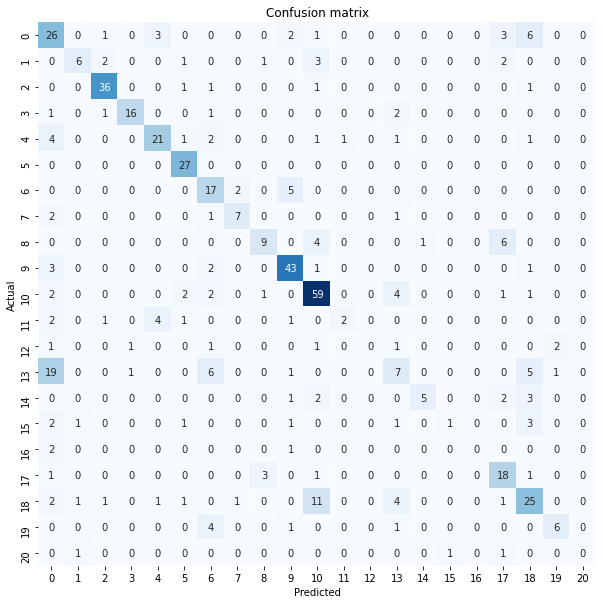


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.503046  | 294.638167 |   11.25   |   3.84   
Validation loss decreased (inf --> 294.638167).  Saving model ...
   2    |  356.781434  | 287.980301 |   11.41   |   3.86   
Validation loss decreased (294.638167 --> 287.980301).  Saving model ...
   3    |  339.454822  | 271.448987 |   19.38   |   4.08   
Validation loss decreased (287.980301 --> 271.448987).  Saving model ...
   4    |  322.087138  | 259.154500 |   19.22   |   3.85   
Validation loss decreased (271.448987 --> 259.154500).  Saving model ...
   5    |  297.568208  | 228.836642 |   31.83   |   3.86   
Validation loss decreased (259.154500 --> 228.836642).  Saving model ...
   6    |  267.093673  | 211.022529 |   38.94   |   3.88   
Validation loss decreased (228.836642 --> 211.022529).  Saving model ...

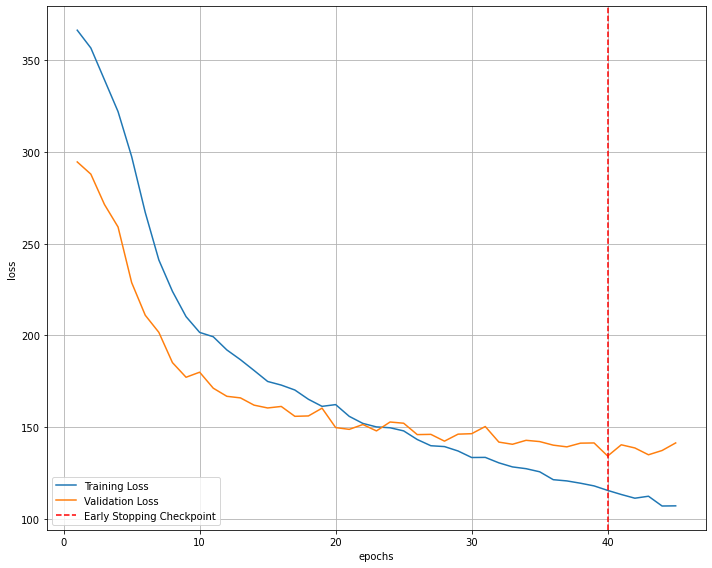

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.50      0.40      0.45        42
           1       0.45      0.33      0.38        15
           2       0.75      0.90      0.82        40
           3       0.68      0.75      0.71        20
           4       0.51      0.64      0.57        33
           5       0.89      0.89      0.89        28
           6       0.60      0.75      0.67        24
           7       0.78      0.64      0.70        11
           8       0.47      0.35      0.40        20
           9       0.79      0.90      0.84        50
          10       0.61      0.78      0.68        72
          11       0.75      0.27      0.40        11
          12       0.33      0.14      0.20         7
          13       0.42      0.33      0.37        40
          14       0.70      0.54      0.61        13
          15       0.67      0.40      0.50        10
          16       0.00      0.00

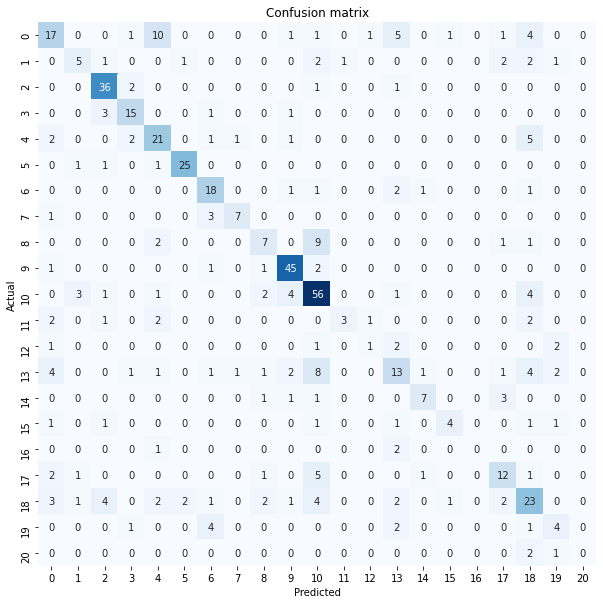


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.021664  | 294.042674 |   11.25   |   3.88   
Validation loss decreased (inf --> 294.042674).  Saving model ...
   2    |  357.410320  | 288.826507 |   16.41   |   4.06   
Validation loss decreased (294.042674 --> 288.826507).  Saving model ...
   3    |  345.504005  | 266.909360 |   19.53   |   3.88   
Validation loss decreased (288.826507 --> 266.909360).  Saving model ...
   4    |  324.319806  | 262.368032 |   19.38   |   3.98   
Validation loss decreased (266.909360 --> 262.368032).  Saving model ...
   5    |  299.539631  | 229.362131 |   26.88   |   3.89   
Validation loss decreased (262.368032 --> 229.362131).  Saving model ...
   6    |  270.388557  | 206.494357 |   34.95   |   3.86   
Validation loss decreased (229.362131 --> 206.494357).  Saving model ...

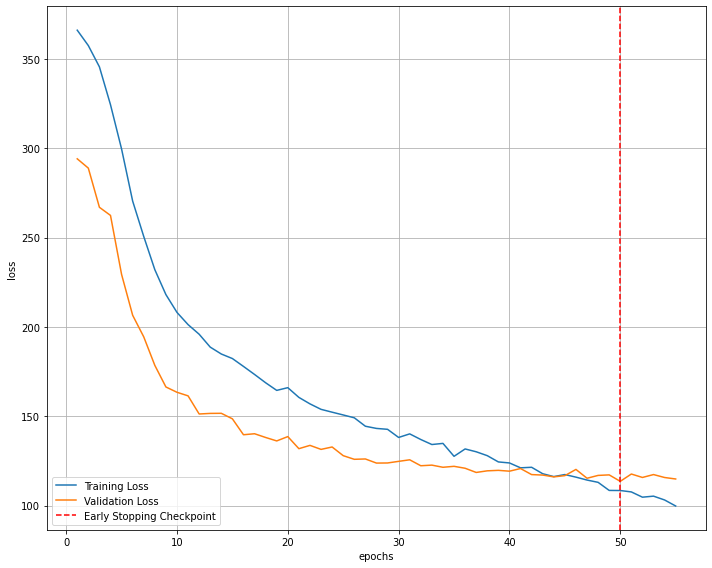

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.55      0.64      0.59        42
           1       0.75      0.43      0.55        14
           2       0.78      0.97      0.87        40
           3       0.78      0.70      0.74        20
           4       0.63      0.67      0.65        33
           5       0.76      0.93      0.84        28
           6       0.63      0.79      0.70        24
           7       0.50      0.73      0.59        11
           8       0.81      0.65      0.72        20
           9       0.86      0.88      0.87        50
          10       0.80      0.83      0.82        72
          11       0.40      0.18      0.25        11
          12       0.50      0.29      0.36         7
          13       0.39      0.30      0.34        40
          14       0.41      0.54      0.47        13
          15       0.50      0.50      0.50        10
          16       0.00      0.00

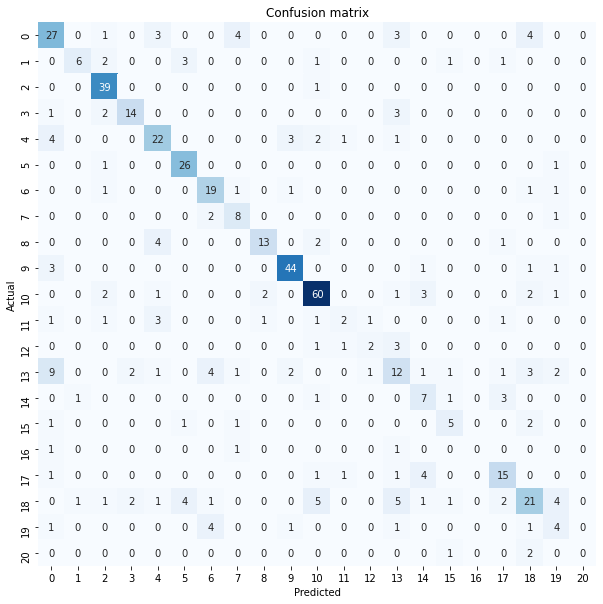


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.999653  | 294.257328 |   11.25   |   3.87   
Validation loss decreased (inf --> 294.257328).  Saving model ...
   2    |  357.759588  | 286.815598 |   11.25   |   3.88   
Validation loss decreased (294.257328 --> 286.815598).  Saving model ...
   3    |  344.762376  | 270.418476 |   16.88   |   3.88   
Validation loss decreased (286.815598 --> 270.418476).  Saving model ...
   4    |  322.892544  | 248.339532 |   25.16   |   3.89   
Validation loss decreased (270.418476 --> 248.339532).  Saving model ...
   5    |  288.164741  | 221.698442 |   28.44   |   3.86   
Validation loss decreased (248.339532 --> 221.698442).  Saving model ...
   6    |  259.432906  | 193.654056 |   46.55   |   3.96   
Validation loss decreased (221.698442 --> 193.654056).  Saving model ...

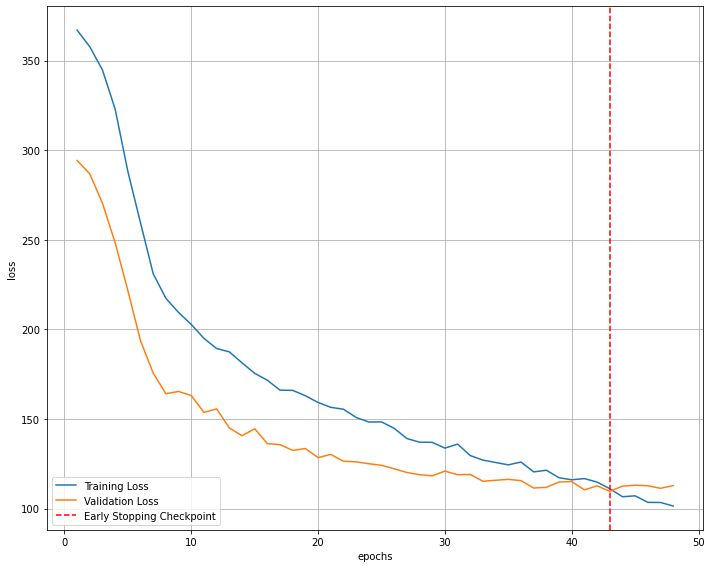

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.42      0.71      0.53        42
           1       1.00      0.36      0.53        14
           2       0.76      0.88      0.81        40
           3       0.71      0.75      0.73        20
           4       0.66      0.58      0.61        33
           5       0.78      1.00      0.88        28
           6       0.71      0.74      0.72        23
           7       0.67      0.55      0.60        11
           8       0.83      0.75      0.79        20
           9       0.84      0.82      0.83        50
          10       0.71      0.82      0.76        72
          11       0.60      0.55      0.57        11
          12       0.75      0.86      0.80         7
          13       0.61      0.42      0.50        40
          14       0.53      0.71      0.61        14
          15       1.00      0.30      0.46        10
          16       0.50      0.33

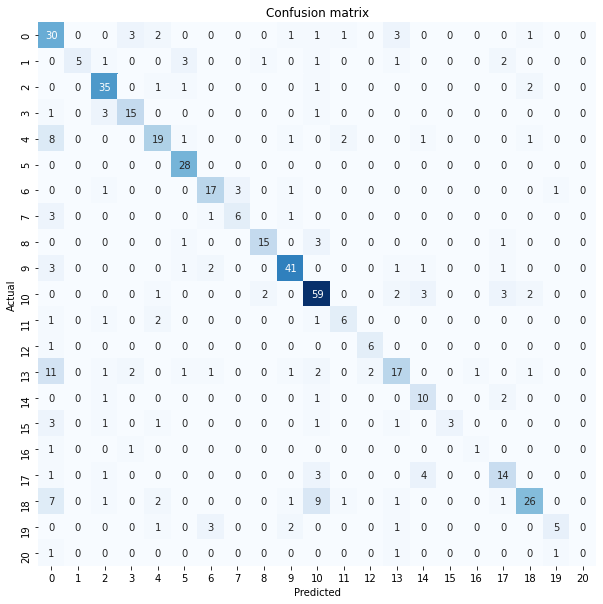


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  365.872469  | 293.941167 |   11.25   |   3.85   
Validation loss decreased (inf --> 293.941167).  Saving model ...
   2    |  357.399109  | 292.698765 |   15.78   |   4.13   
Validation loss decreased (293.941167 --> 292.698765).  Saving model ...
   3    |  344.684902  | 279.952331 |   17.81   |   3.90   
Validation loss decreased (292.698765 --> 279.952331).  Saving model ...
   4    |  315.008387  | 239.089273 |   27.66   |   3.88   
Validation loss decreased (279.952331 --> 239.089273).  Saving model ...
   5    |  282.139404  | 214.151127 |   32.94   |   3.87   
Validation loss decreased (239.089273 --> 214.151127).  Saving model ...
   6    |  256.416573  | 197.936367 |   35.78   |   3.91   
Validation loss decreased (214.151127 --> 197.936367).  Saving model ...

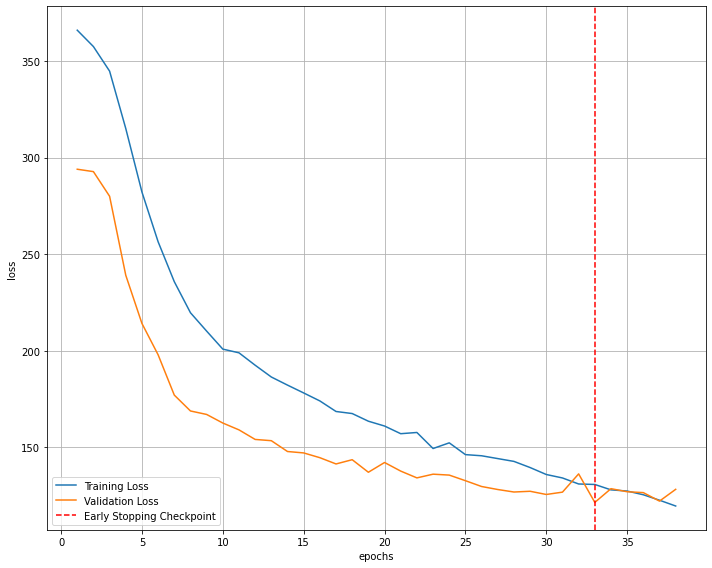

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.44      0.57      0.49        42
           1       0.43      0.21      0.29        14
           2       0.74      0.72      0.73        40
           3       0.72      0.90      0.80        20
           4       0.65      0.73      0.69        33
           5       0.75      0.89      0.81        27
           6       0.89      0.71      0.79        24
           7       0.86      0.55      0.67        11
           8       0.75      0.60      0.67        20
           9       0.77      0.86      0.81        51
          10       0.58      0.83      0.68        72
          11       0.33      0.09      0.14        11
          12       0.00      0.00      0.00         7
          13       0.54      0.33      0.41        40
          14       1.00      0.71      0.83        14
          15       0.80      0.40      0.53        10
          16       0.00      0.00

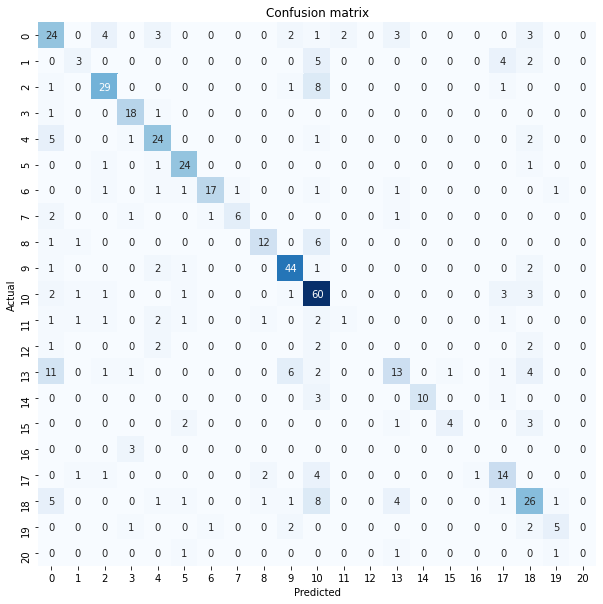


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.829136  | 294.153936 |   11.25   |   3.86   
Validation loss decreased (inf --> 294.153936).  Saving model ...
   2    |  357.489907  | 285.193084 |   11.25   |   3.89   
Validation loss decreased (294.153936 --> 285.193084).  Saving model ...
   3    |  345.048366  | 268.014692 |   17.34   |   3.88   
Validation loss decreased (285.193084 --> 268.014692).  Saving model ...
   4    |  317.834703  | 247.505067 |   25.16   |   3.88   
Validation loss decreased (268.014692 --> 247.505067).  Saving model ...
   5    |  290.090585  | 226.845652 |   28.28   |   3.93   
Validation loss decreased (247.505067 --> 226.845652).  Saving model ...
   6    |  267.759982  | 200.320473 |   40.35   |   3.89   
Validation loss decreased (226.845652 --> 200.320473).  Saving model ...

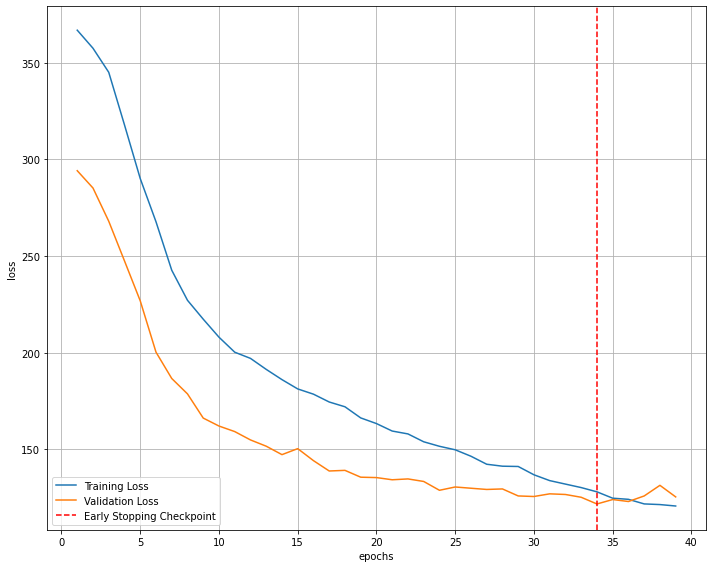

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.45      0.60      0.51        42
           1       0.39      0.50      0.44        14
           2       0.80      0.95      0.87        41
           3       0.68      0.85      0.76        20
           4       0.73      0.50      0.59        32
           5       0.88      0.85      0.87        27
           6       0.71      0.83      0.77        24
           7       0.53      0.73      0.62        11
           8       0.57      0.81      0.67        21
           9       0.81      0.86      0.84        51
          10       0.82      0.74      0.77        72
          11       0.09      0.09      0.09        11
          12       0.00      0.00      0.00         7
          13       0.25      0.10      0.15        39
          14       0.82      0.69      0.75        13
          15       0.56      0.45      0.50        11
          16       0.00      0.00

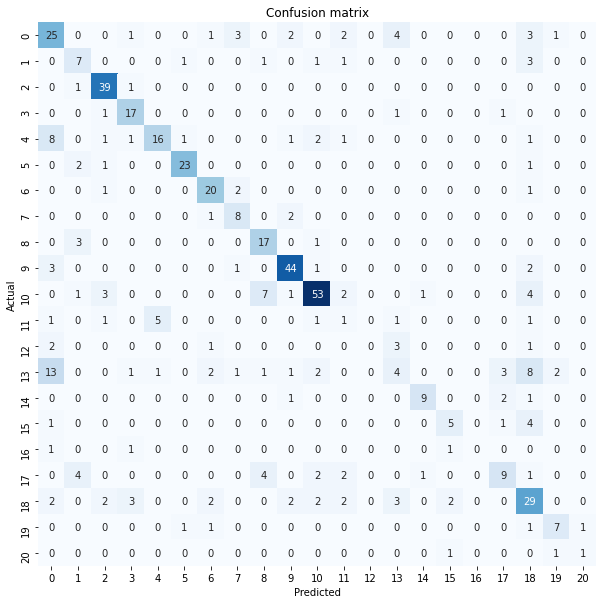


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.778570  | 294.827005 |   11.25   |   3.88   
Validation loss decreased (inf --> 294.827005).  Saving model ...
   2    |  356.864853  | 281.297893 |   11.25   |   4.09   
Validation loss decreased (294.827005 --> 281.297893).  Saving model ...
   3    |  342.866846  | 264.925885 |   20.31   |   3.87   
Validation loss decreased (281.297893 --> 264.925885).  Saving model ...
   4    |  321.011710  | 256.090339 |   20.31   |   3.89   
Validation loss decreased (264.925885 --> 256.090339).  Saving model ...
   5    |  301.889258  | 230.458339 |   27.34   |   3.89   
Validation loss decreased (256.090339 --> 230.458339).  Saving model ...
   6    |  275.033259  | 209.607115 |   36.31   |   3.87   
Validation loss decreased (230.458339 --> 209.607115).  Saving model ...

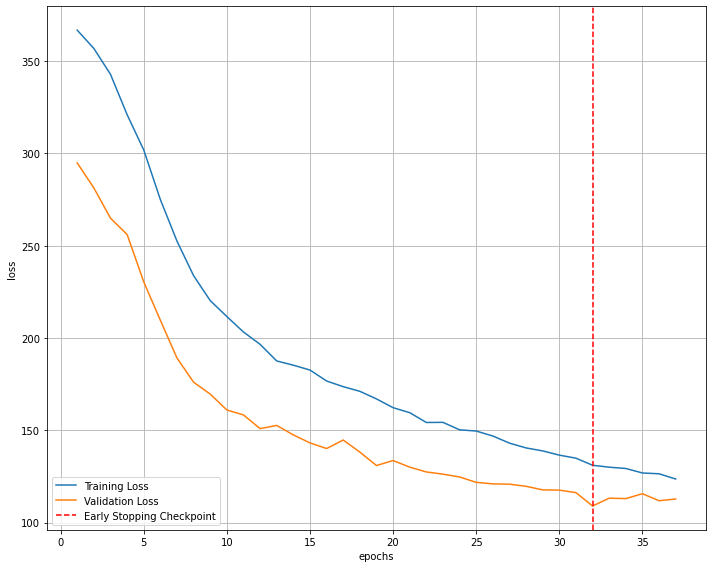

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.42      0.60      0.50        42
           1       0.50      0.50      0.50        14
           2       0.88      0.85      0.86        41
           3       0.63      0.81      0.71        21
           4       0.43      0.41      0.42        32
           5       0.77      1.00      0.87        27
           6       0.83      0.79      0.81        24
           7       0.50      0.50      0.50        10
           8       0.81      0.81      0.81        21
           9       0.94      0.88      0.91        51
          10       0.83      0.86      0.84        72
          11       0.50      0.40      0.44        10
          12       0.00      0.00      0.00         8
          13       0.47      0.35      0.40        40
          14       0.79      0.85      0.81        13
          15       0.60      0.30      0.40        10
          16       0.00      0.00

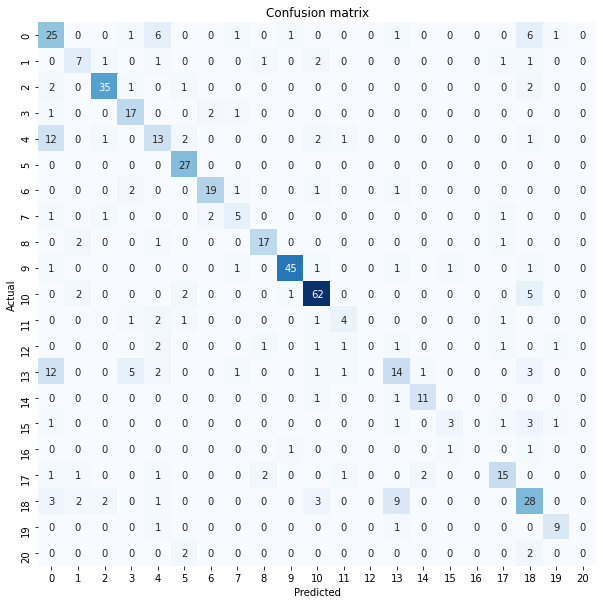


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  365.157457  | 292.449429 |   11.25   |   3.88   
Validation loss decreased (inf --> 292.449429).  Saving model ...
   2    |  353.732075  | 287.288890 |   17.71   |   3.85   
Validation loss decreased (292.449429 --> 287.288890).  Saving model ...
   3    |  328.921056  | 252.081737 |   22.03   |   3.88   
Validation loss decreased (287.288890 --> 252.081737).  Saving model ...
   4    |  296.993151  | 227.764302 |   30.57   |   3.87   
Validation loss decreased (252.081737 --> 227.764302).  Saving model ...
   5    |  272.580917  | 210.213823 |   34.90   |   3.88   
Validation loss decreased (227.764302 --> 210.213823).  Saving model ...
   6    |  251.523130  | 187.723691 |   40.68   |   3.86   
Validation loss decreased (210.213823 --> 187.723691).  Saving model ...

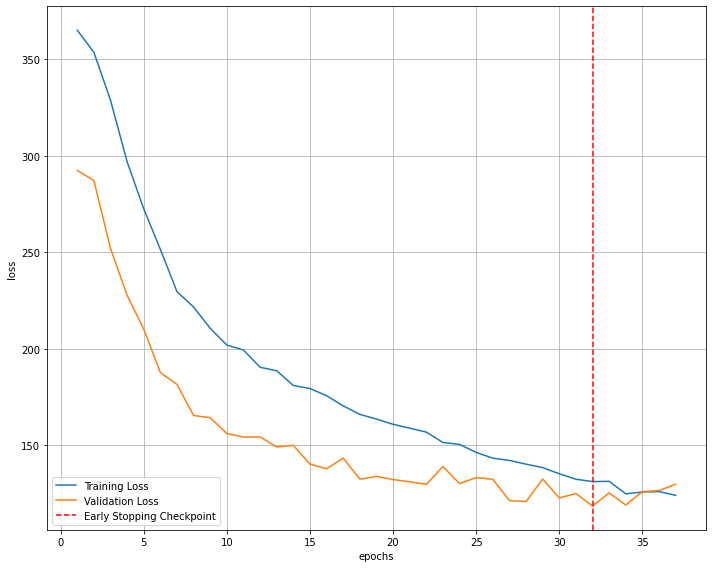

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.38      0.36      0.37        42
           1       0.50      0.14      0.22        14
           2       0.83      0.95      0.89        41
           3       0.78      0.86      0.82        21
           4       0.61      0.62      0.62        32
           5       0.88      0.81      0.85        27
           6       0.67      0.67      0.67        24
           7       0.67      0.80      0.73        10
           8       0.91      0.48      0.62        21
           9       0.84      0.84      0.84        51
          10       0.74      0.86      0.79        72
          11       0.14      0.10      0.12        10
          12       0.67      0.25      0.36         8
          13       0.36      0.47      0.41        40
          14       0.69      0.69      0.69        13
          15       0.33      0.20      0.25        10
          16       0.00      0.00

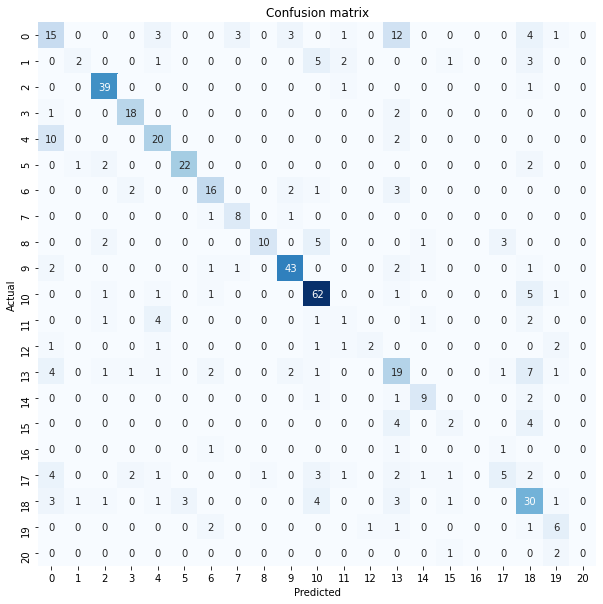


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  367.362299  | 293.224612 |   11.25   |   3.89   
Validation loss decreased (inf --> 293.224612).  Saving model ...
   2    |  358.620795  | 290.103100 |   11.25   |   4.05   
Validation loss decreased (293.224612 --> 290.103100).  Saving model ...
   3    |  343.167645  | 266.370604 |   16.72   |   3.88   
Validation loss decreased (290.103100 --> 266.370604).  Saving model ...
   4    |  323.434890  | 254.715285 |   21.56   |   3.89   
Validation loss decreased (266.370604 --> 254.715285).  Saving model ...
   5    |  307.304630  | 238.352257 |   24.69   |   3.89   
Validation loss decreased (254.715285 --> 238.352257).  Saving model ...
   6    |  284.859300  | 214.923809 |   28.59   |   3.87   
Validation loss decreased (238.352257 --> 214.923809).  Saving model ...

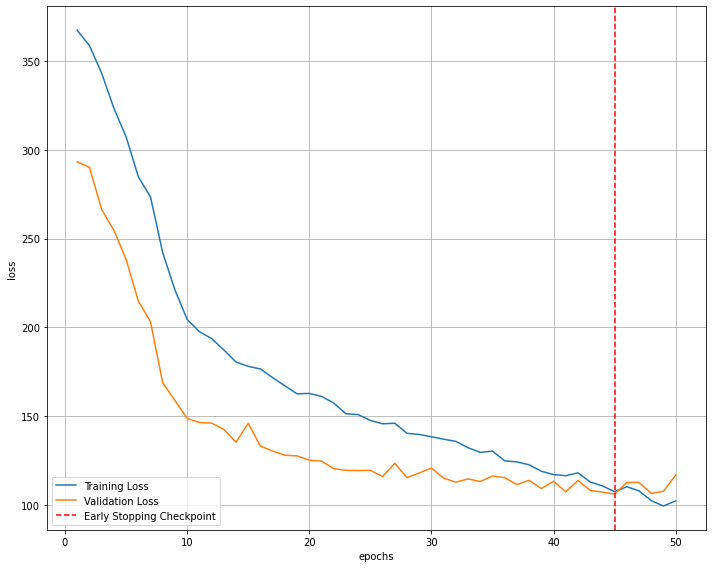

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.51      0.55      0.53        42
           1       0.50      0.36      0.42        14
           2       0.91      0.72      0.81        40
           3       0.86      0.86      0.86        21
           4       0.69      0.78      0.74        32
           5       0.60      0.93      0.72        27
           6       0.70      0.88      0.78        24
           7       0.56      0.50      0.53        10
           8       0.68      0.75      0.71        20
           9       0.83      0.86      0.85        51
          10       0.73      0.88      0.80        72
          11       0.50      0.30      0.37        10
          12       1.00      0.50      0.67         8
          13       0.58      0.35      0.44        40
          14       0.56      0.69      0.62        13
          15       0.50      0.30      0.37        10
          16       1.00      0.67

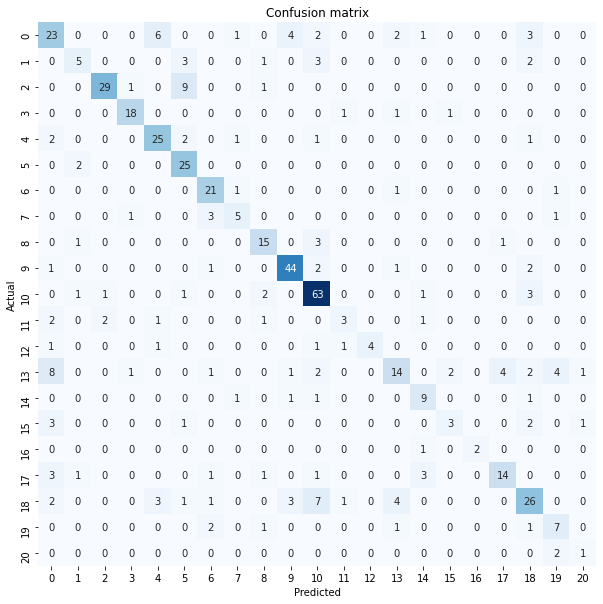


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.216023  | 292.856978 |   11.25   |   3.85   
Validation loss decreased (inf --> 292.856978).  Saving model ...
   2    |  355.975286  | 282.447075 |   17.24   |   3.87   
Validation loss decreased (292.856978 --> 282.447075).  Saving model ...
   3    |  337.903384  | 264.260024 |   16.88   |   3.88   
Validation loss decreased (282.447075 --> 264.260024).  Saving model ...
   4    |  312.355004  | 243.240666 |   33.23   |   3.90   
Validation loss decreased (264.260024 --> 243.240666).  Saving model ...
   5    |  288.578806  | 224.796478 |   35.26   |   3.88   
Validation loss decreased (243.240666 --> 224.796478).  Saving model ...
   6    |  267.505267  | 206.783538 |   38.28   |   3.87   
Validation loss decreased (224.796478 --> 206.783538).  Saving model ...

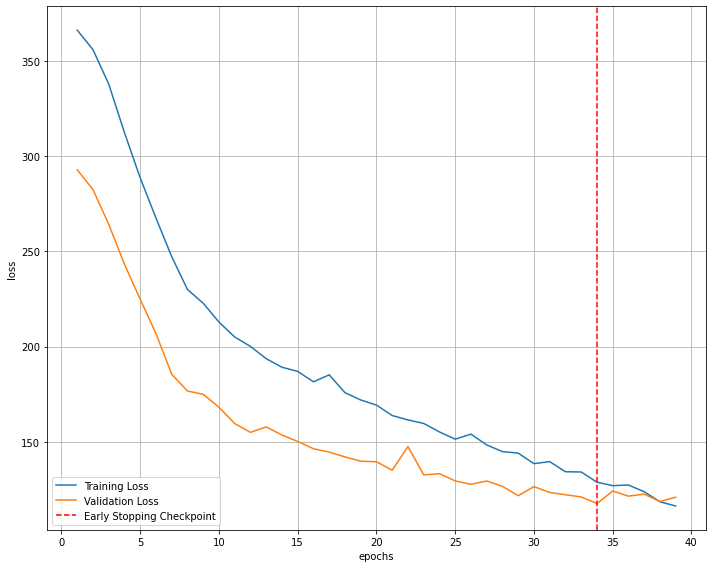

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.54      0.50      0.52        42
           1       0.67      0.27      0.38        15
           2       0.86      0.90      0.88        40
           3       0.91      0.95      0.93        21
           4       0.59      0.75      0.66        32
           5       0.68      0.85      0.75        27
           6       0.73      0.79      0.76        24
           7       0.70      0.64      0.67        11
           8       0.71      0.75      0.73        20
           9       0.83      0.88      0.85        50
          10       0.73      0.65      0.69        72
          11       0.11      0.09      0.10        11
          12       0.40      0.29      0.33         7
          13       0.53      0.65      0.58        40
          14       1.00      0.38      0.56        13
          15       0.44      0.40      0.42        10
          16       0.00      0.00

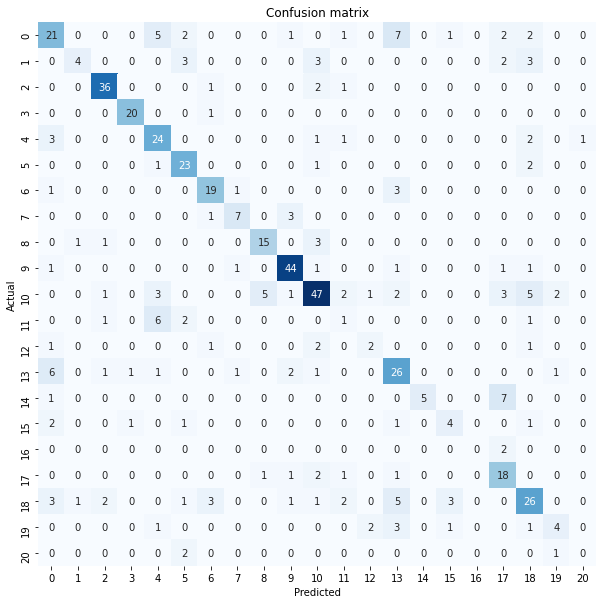

In [54]:
####### Setting up Cross-Validation #####
y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

####### Cross-Validation Loop ############

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    

  ####### Instantiate model ############  
    model = ClassificationRNN(
                        pretrained_embedding=embeddings, 
                        output_dim=output_dim,
                        dropout=dropout_pc,
                        hidden_dim=hidden_dim,
                        num_layers=num_layers,
                        bidirectional=bidirectional
                        )
    
    model=model.double()

    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    ####### Compute Accuracy ##########
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))

    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])

    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break

     ## Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


## Results Output

In [55]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f}  +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 64.97 +/- 2.43 max: 68.19

CV precision: 64.32 +/- 3.18 max: 70.24

CV recall: 64.97 +/- 2.43 max: 68.19

CV f1: 63.55 +/- 2.79 max: 67.45

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 45.93  +/- 5.87  | 55.48 +/-10.27  | 49.62 +/- 5.67  |   42.00  
   1    | 58.55  +/-17.73  | 35.00 +/-11.06  | 41.99 +/-10.00  |   14.30  
   2    | 81.56  +/- 5.43  | 87.56 +/- 8.30  | 84.12 +/- 4.54  |   40.30  
   3    | 76.41  +/- 9.06  | 81.88 +/- 7.43  | 78.73 +/- 6.76  |   20.50  
   4    | 62.15  +/- 8.82  | 63.25 +/-10.89  | 62.22 +/- 8.26  |   32.40  
   5    | 77.65  +/- 8.93  | 91.55 +/- 6.42  | 83.55 +/- 5.29  |   27.30  
   6    | 69.34  +/-11.31  | 76.56 +/- 5.99  | 72.24 +/- 7.25  |   23.90  
   7    | 64.57  +/-11.50  | 62.55 +/- 9.79  | 62.62 +/- 6.96  |   10.70  
   8    | 71.87  +/-12.70  | 63.95 +/-15.57  | 66.55 +/-11.69  |   20.30  
   9    | 82.85  +/- 4.68  |